In [2]:
import plotly.graph_objects as go
import pandas as pd

def draw_graph(df):
  #create figure
  fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

  fig.show()

def draw_graph_simple(df):
  fig = go.Figure(data=[go.Line(x=df.index,y=df['close'])])
  fig.show()

# Loading Data

In [3]:
size = 1000
data = pd.read_csv('../data/bnb21.csv').tail(size)
slice_ = slice(0,size)
data = data.iloc[::-1].set_index('unix')
sample = data.iloc[slice_][["close"]].to_numpy().flatten()
sample_original = sample.copy()

In [4]:
draw_graph_simple(data)

c:\users\clementich\appdata\local\programs\python\python37\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning: plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.

  DeprecationWarning,


# Grab Turning Points

In [5]:
import numpy as np
from scipy.signal import argrelextrema

maxima = argrelextrema(sample, np.greater)
minima = argrelextrema(sample, np.less)

extrema = np.concatenate((maxima,minima), axis=1)[0]
extrema_prices = np.concatenate((sample[maxima], sample[minima]))

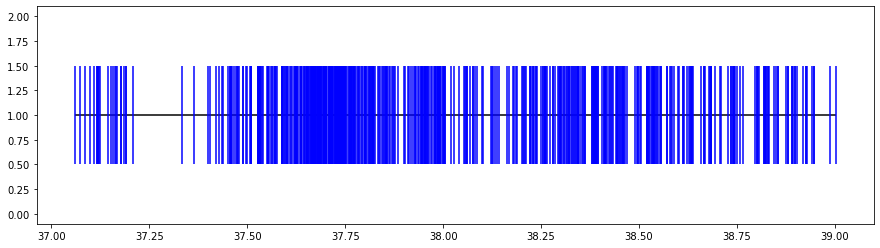

In [6]:
from matplotlib import pyplot as plt

f = plt.figure()
f.set_figwidth(15)
plt.hlines(1,sample_original.min(), sample_original.max())
plt.eventplot(extrema_prices,  orientation='horizontal', colors='b')
# plt.show(f)

# Estimate PDF

In [7]:
# plt.plot(data.index, data['close'])
# for x in extrema_prices:
#   plt.hlines(x, xmin=data.index[0], xmax=data.index[-1])

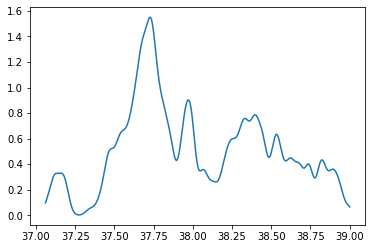

In [8]:
from sklearn.neighbors import KernelDensity

initial_price = extrema_prices[0]
bandwidth = 1535
kde = KernelDensity(kernel='gaussian', bandwidth=initial_price/bandwidth).fit(extrema_prices.reshape(-1,1))
a,b = min(extrema_prices), max(extrema_prices)
price_range = np.linspace(a, b, 1000).reshape(-1,1)
pdf = np.exp(kde.score_samples(price_range))
plt.plot(price_range, pdf)

# Plot Results

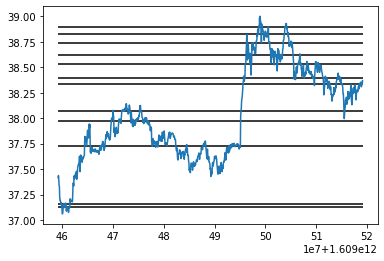

In [9]:
from scipy.signal import find_peaks
peaks = find_peaks(pdf)[0]
plt.plot(data.index, data['close'])
for x in peaks:
  plt.hlines(price_range[x], xmin=data.index[0], xmax=data.index[-1])

# Automated Bandwidth selection 

In [10]:
from scipy.signal import argrelextrema, find_peaks
from sklearn.neighbors import KernelDensity

size = 552
slice_ = slice(0, size)
peaks_range = [3,6]
num_peaks = -999
interval = 1.5

sample_df = data.iloc[slice_]
sample = data.iloc[slice_][['close']].to_numpy().flatten()
sample_original = sample.copy()

maxima = argrelextrema(sample, np.greater)
minima = argrelextrema(sample, np.less)

extrema = np.concatenate((maxima,minima), axis=1)[0]
extrema_prices = np.concatenate((sample[maxima], sample[minima]))

bandwidth = interval

while num_peaks < peaks_range[0] or num_peaks > peaks_range[1]:
  initial_price = extrema_prices[0]
  kde = KernelDensity(kernel='gaussian', bandwidth=initial_price/bandwidth).fit(extrema_prices.reshape(-1,1))
  a,b = min(extrema_prices), max(extrema_prices)
  price_range = np.linspace(a, b, 1000).reshape(-1,1)
  pdf = np.exp(kde.score_samples(price_range))
  peaks = find_peaks(pdf)[0]

  num_peaks = len(peaks)
  bandwidth *= interval

  if bandwidth > 100000 * interval:
    print("Failed to converge.")
    break

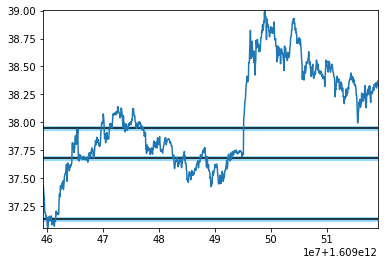

In [11]:
bands = []
band = 1.0005
fig, axes = plt.subplots(1,1)
axes.plot(data.index, data['close'])

for x in peaks:
  low = price_range[x][0] / band
  high = price_range[x][0] * band
  bands.append([low, high])
  axes.hlines(price_range[x], xmin=data.index[0], xmax=data.index[-1])
  axes.add_patch(plt.Rectangle(xy=(data.index[0],low), width=data.index[-1] - data.index[0], height=high-low, color='#96dbff'))
  axes.margins(0)
  axes.set_xlim(left=data.index[0], right=data.index[-1])


# bands

In [12]:
# Detect entry/exit from band
sample_df[['open', 'high', 'low', 'close']]

,open,high,low,close
unix,,,,
1609459200000,37.4121,37.4258,37.3931,37.4160
1609459260000,37.4231,37.4707,37.4049,37.4362
1609459320000,37.4448,37.4460,37.3686,37.3969
1609459380000,37.3847,37.3847,37.3398,37.3398
1609459440000,37.3381,37.3581,37.3160,37.3314
...,...,...,...,...
1609492020000,37.6068,37.6491,37.6068,37.6248
1609492080000,37.6178,37.6619,37.6178,37.6619
1609492140000,37.6647,37.6666,37.6455,37.6470
